In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import numpy as np

In [16]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams["axes.labelsize"] = 23
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 28
mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [17]:
num_seeds = 10
out_path = "../output"
SAMPLE_SIZES = [5, 10, 25, 50, 100]
DATASET = "imagenet_captions"
N_TASKS = 5

model_names = {
    'RN50': 'ResNet50', 
    'nllb-clip-base': 'NLLB-CLIP', 
    'ViT-B-32': 'ViT-B/32'
}

color1 = "navy"
color5 = "tab:red"

In [26]:
def load_result(dataset, model, task_id, sample_size, seed):
    templates = f"{dataset}/task_{task_id:02d}_sample_size_{sample_size}_seed_{seed:02d}"
    with open(os.path.join(out_path, f"{model}/{templates}.json"), 'r') as f:
        result = json.load(f)
    return result["acc1"], result["acc5"][0]

def load_baseline(dataset, model, task_id):
    pretrained = {
        'RN50':'yfcc15m',
        'nllb-clip-base': 'v1',
        'ViT-B-32': 'datacomp_m_s128m_b4k',
    }[model]
    out_fp = os.path.join(out_path, f"{model}/{pretrained}/imagenet1k_{N_TASKS}_tasks_{task_id}.json")
    with open(out_fp, 'r') as file:
        result = json.load(file)
    return result["acc1"], result["acc5"][0]

def create_ax(ax, task_id, model, linewidth=3, zscore=1.96, capsize=4, s=5):
    ns = np.array(SAMPLE_SIZES)
    acc1 = np.zeros(shape=(len(ns), num_seeds))
    acc5 = np.zeros(shape=(len(ns), num_seeds))
    for i, n in enumerate(ns):
        for j, seed in enumerate(range(num_seeds)):
            acc1[i, j], acc5[i, j] = load_result(DATASET, model, task_id, n, seed)
    ax.errorbar(
        ns, 
        acc1.mean(axis=1), 
        yerr=zscore * acc1.std(axis=1), 
        color=color1, 
        linewidth=linewidth, 
        elinewidth=linewidth,
        capsize=capsize,
        capthick=linewidth,
        fmt=".-",
        markersize=2 * s,
        label="Top-1 (Ideal)"
    )
    ax.errorbar(
        ns, 
        acc5.mean(axis=1), 
        yerr=zscore * acc5.std(axis=1), 
        color=color5, 
        linewidth=linewidth, 
        elinewidth=linewidth,
        capsize=capsize,
        capthick=linewidth,
        fmt="s-",
        markersize=s,
        label="Top-5 (Ideal)"
    )
    # template lines
    acc1_base, acc5_base = load_baseline(DATASET, model, task_id)
    ax.hlines(y=acc1_base, xmin=ns.min(), xmax=ns.max(), linestyle="dotted", linewidth=1.5 * linewidth, color=color1, label="Top-1 (Templates)")
    ax.hlines(y=acc5_base, xmin=ns.min(), xmax=ns.max(), linestyle="dotted", linewidth=1.5 * linewidth, color=color5, label="Top-5 (Templates)")
    

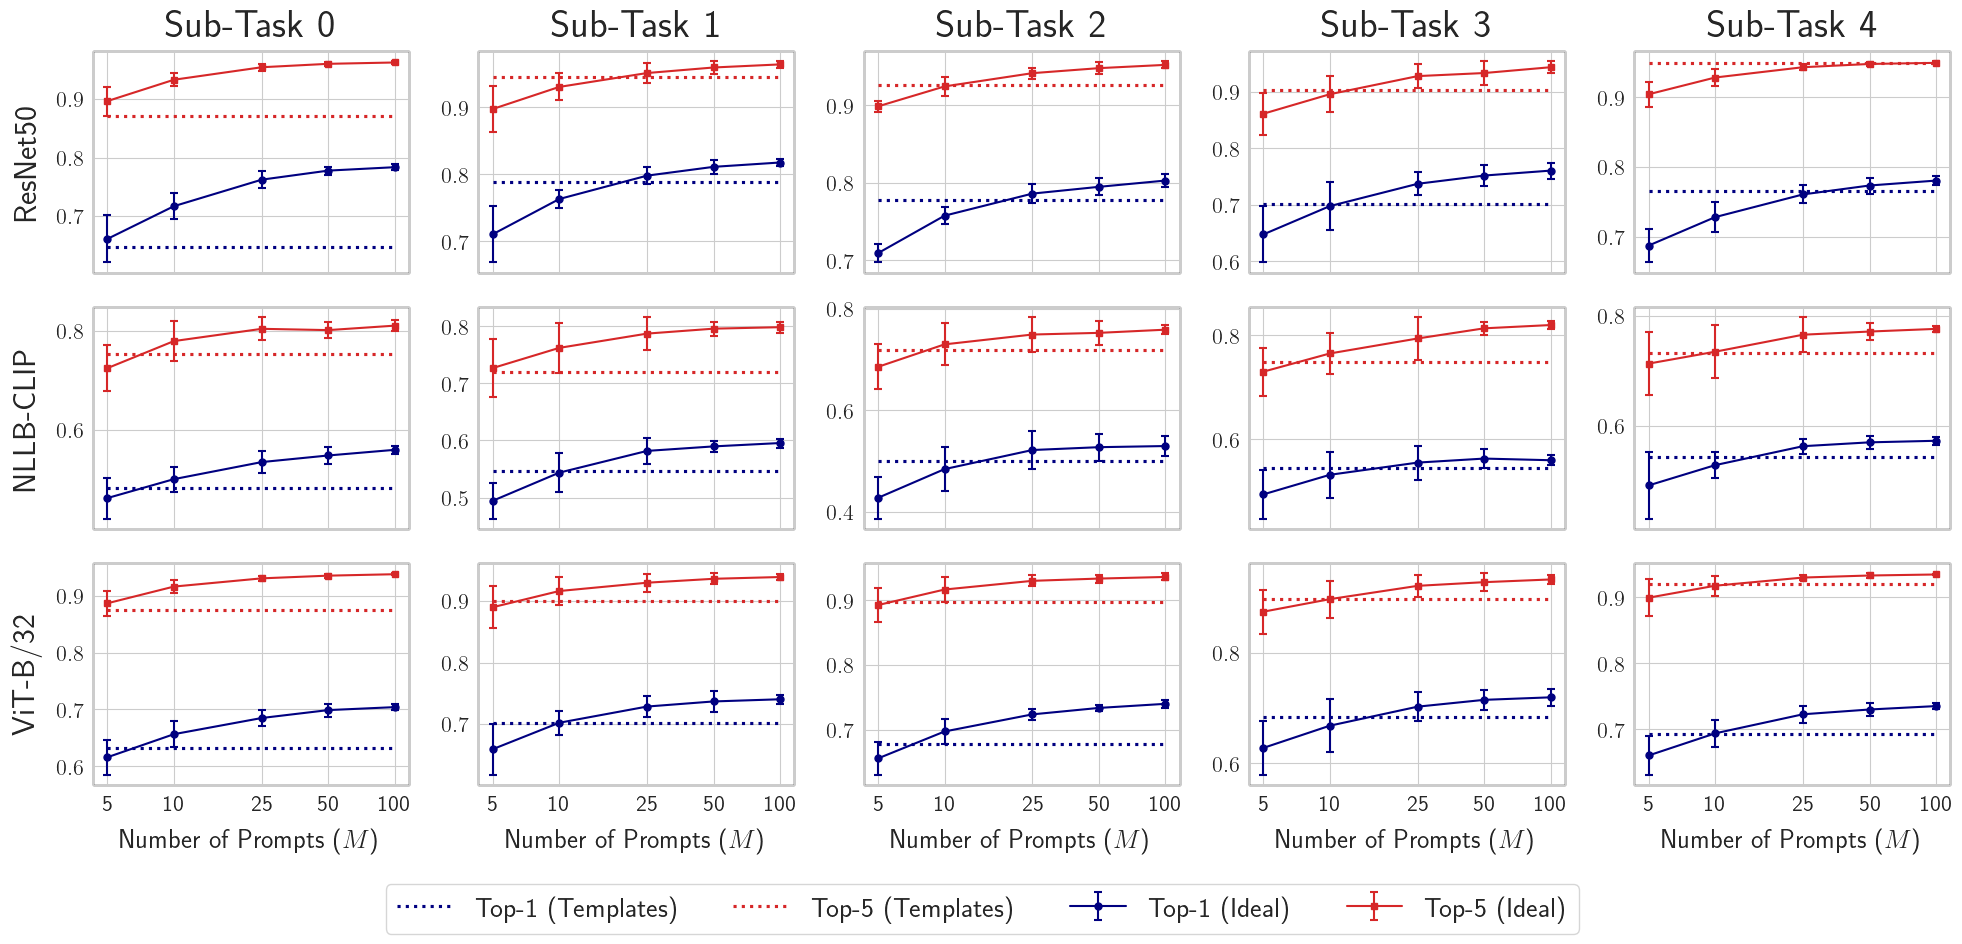

In [31]:
sns.set_style("whitegrid")

scale = 4
linewidth = 1.5
capsize = 3
fig, axes = plt.subplots(len(model_names), N_TASKS, figsize=(scale * N_TASKS, 0.75 * scale * len(model_names)), sharex="col")

for i, model in enumerate(model_names):
    axes[i, 0].set_ylabel(model_names[model], labelpad=10)
    for j in range(N_TASKS):
        axes[i, j].patch.set_edgecolor('black')  
        axes[i, j].patch.set_linewidth(1)  
        if i == 0:
            axes[i, j].set_title(f"Sub-Task {j}", y=1.03)
        if i == len(model_names) - 1:
            axes[i, j].set_xlabel(r"Number of Prompts ($M$)", labelpad=10, fontsize=19)
        create_ax(axes[i, j], j, model, linewidth=linewidth, capsize=capsize)
        axes[i, j].set_xscale("log")
        axes[i, j].set_xticks(SAMPLE_SIZES)
        axes[i, j].set_xticklabels([str(M) for M in SAMPLE_SIZES])


handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, -0.03), ncol=4)

fig.tight_layout(pad=2.0)
plt.savefig("../figures/ideal_prompting.pdf", bbox_inches="tight")
plt.show()